# Pair Selection

This is a proof of concept for selecting pairs of stocks that are cointegrated. Note that this requires an API key, so follow the instructions in the README to get one.

The process is as follows:

1. Get the prices for a list of stocks
2. Resample the prices to a common time frame (e.g. 1 hour)
3. For each pair of stocks, self-normalize the prices by their respective means. Calculate their spread and determine if it is stationary using the ADF test.

## tldr

This seems promising. Not sure how to handle normalizing the spread yet - it seems like a good idea, but I don't know how to calculate the mean for each price. Maybe it can be calculated at the start of each day?

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import holidays
import pytz
from datetime import time

load_dotenv()

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_API_SECRET = os.getenv("ALPACA_API_SECRET")
DATA_DIR = "../data"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.alpha"] = 0.7
plt.rcParams["axes.grid"] = True
nyse_holidays = holidays.NYSE()  # this is a dict-like object
eastern = pytz.timezone("US/Eastern")




def save_dataframe(df: pd.DataFrame, filename: str, data_dir: str = DATA_DIR):
    """Save the data to a CSV and pickle file."""
    path = os.path.join(data_dir, filename)
    df.to_csv(path + ".csv")
    df.to_pickle(path + ".pkl")

In [2]:
utility_tickers = [
    "NEE", "EXC", "D", "PCG", "XEL", 
    "ED", "WEC", "DTE", "PPL", "AEE", 
    "CNP", "FE", "CMS", "EIX", "ETR", 
    "EVRG", "LNT", "PNW", "IDA", "AEP", 
    "DUK", "SRE", "ATO", "NRG",
]
refresh_bars = False

In [3]:

client = StockHistoricalDataClient(api_key=ALPACA_API_KEY, secret_key=ALPACA_API_SECRET)
# Get the utility bars
start_date = datetime(2023, 1, 1)
end_date = datetime.today() - timedelta(minutes=15)
timeframe = TimeFrame.Hour
request_params = StockBarsRequest(
    symbol_or_symbols=utility_tickers,
    timeframe=timeframe,
    start=start_date,
    end=end_date,
    adjustment="all",
)

## Resampling

Resample the bars to a common time frame (e.g. 1 hour)

In [4]:
def resample_multi_ticker_bars(
    bars: pd.DataFrame, time_frame: timedelta = timedelta(hours=1)
) -> pd.DataFrame:
    """Resample the bars to the given time frame and fill the missing values.
    For OHLC, use the last value in the time frame to fill forward.
    For volume and trade count, fill with 0.
    THIS IS FOR MULTIPLE TICKERS. Use groupby to apply to multiple tickers.
    """
    # Create a list to store resampled data for each ticker
    resampled_data = []

    # Get unique tickers
    tickers = bars.index.get_level_values("symbol").unique()

    latest_start = None
    earliest_end = None

    # Process each ticker
    for ticker in tickers:
        # Get data for this ticker
        ticker_data = bars.loc[ticker]
        # start and end of the ticker data
        start = ticker_data.index.get_level_values("timestamp").min()
        end = ticker_data.index.get_level_values("timestamp").max()
        if latest_start is None or start > latest_start:
            latest_start = start
        if earliest_end is None or end < earliest_end:
            earliest_end = end

        # Resample the data
        resampled_ticker = resample_bars(ticker_data, time_frame)
        # Add the ticker back to the index
        resampled_ticker["symbol"] = ticker
        resampled_data.append(resampled_ticker)

    # trim the data to the latest start and earliest end
    for i in range(len(resampled_data)):
        data = resampled_data[i]
        resampled_data[i] = data.loc[latest_start:earliest_end]

    # Combine all resampled data
    result = pd.concat(resampled_data)
    # Set the multi-index
    result.set_index(["symbol", result.index], inplace=True)

    return result

def resample_bars(
    bars: pd.DataFrame, time_frame: timedelta = timedelta(hours=1)
) -> pd.DataFrame:
    """Resample the bars to the given time frame and fill the missing values.
    For OHLC, use the last value in the time frame to fill forward.
    For volume and trade count, fill with 0.
    THIS IS FOR ONE TICKER. Use groupby to apply to multiple tickers.
    """
    # resample the bars
    part1 = bars[["open", "high", "low", "close", "vwap"]]
    part2 = bars[["volume", "trade_count"]]
    part1 = part1.resample(time_frame).last().ffill()
    part2 = part2.resample(time_frame).asfreq().fillna(0)
    bars = pd.concat([part1, part2], axis=1)
    return bars


Refresh or load the actual bars:

In [5]:
if refresh_bars:
    bars = client.get_stock_bars(request_params).df  # get the bars
    save_dataframe(bars, "utility_bars")  # save the bars
    bars = pd.read_pickle(os.path.join(DATA_DIR, "utility_bars.pkl"))  # load the bars
    # resample the bars. apply to each ticker
    bars = resample_multi_ticker_bars(bars)
    save_dataframe(bars, "utility_bars_resampled")
    close_prices = bars["close"].unstack(level=0)  # get the close prices
    save_dataframe(close_prices, "utility_close_prices")  # save the close prices

close_prices = pd.read_pickle(os.path.join(DATA_DIR, "utility_close_prices.pkl"))

Split the price into training and test periods:

In [6]:
tt_split = 0.8
# we want the strategy to train on
train_prices = close_prices.iloc[:int(tt_split * len(close_prices))]
test_prices = close_prices.iloc[int(tt_split * len(close_prices)):]
print(f"Train prices: {train_prices.shape}")
print(f"Test prices: {test_prices.shape}")

Train prices: (17513, 24)
Test prices: (4379, 24)


Plot the price data for the utility stocks:

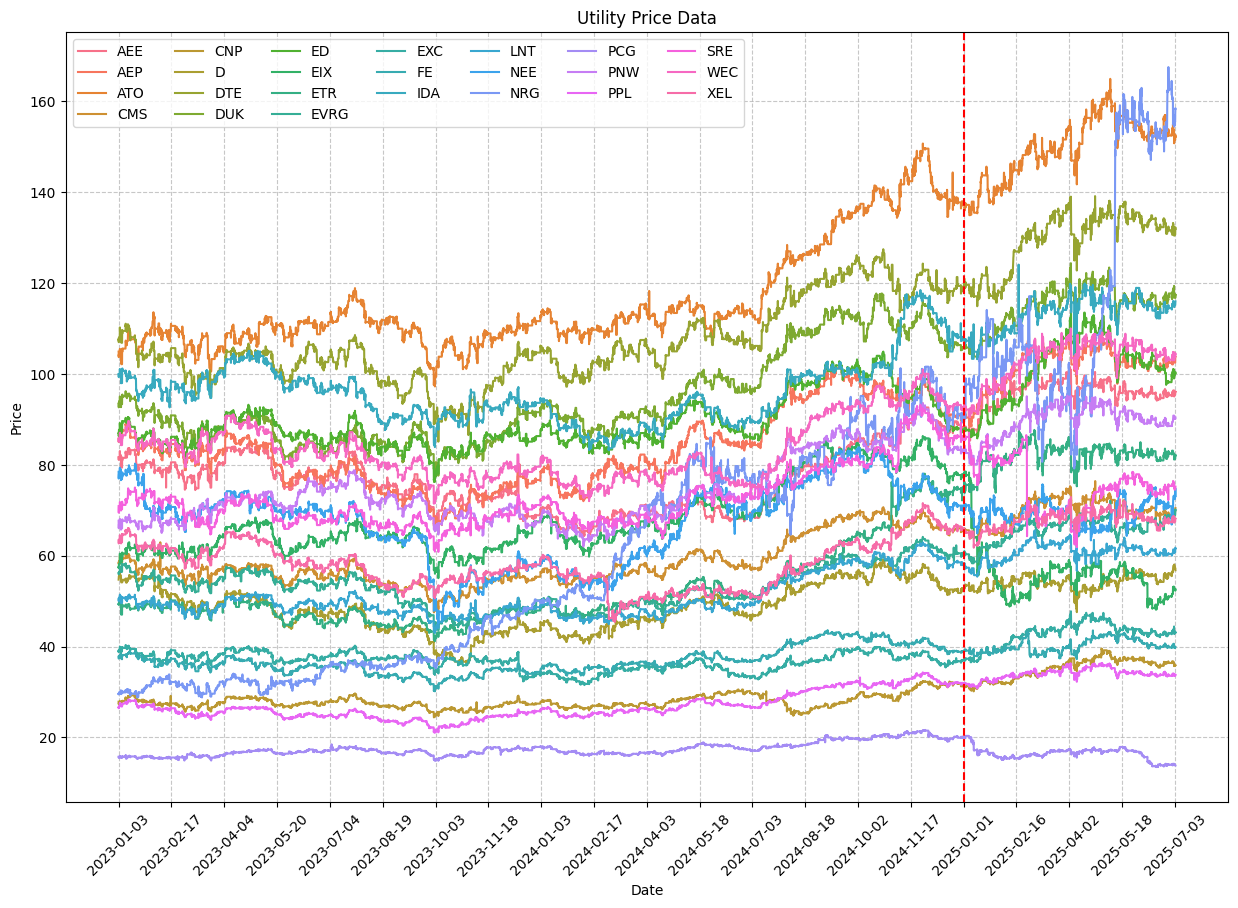

In [7]:

"""Plot the price data."""
plt.figure(figsize=(15, 10))
NUM_COLORS = len(close_prices.columns)
COLORS = sns.color_palette("husl", NUM_COLORS)

# also plot the eps data on its own y axis
plt.xticks(
    close_prices.index[:: len(close_prices) // 20],
    close_prices.index[:: len(close_prices) // 20].strftime("%Y-%m-%d"),
    rotation=45,
)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Utility Price Data")
plt.grid(True, linestyle="--", alpha=0.7)
for i, column in enumerate(close_prices.columns):
    plt.plot(close_prices[column], color=COLORS[i], label=column)
# legend, columns
plt.legend(close_prices.columns, loc="upper left", ncol=len(close_prices.columns) // 4 + 1)

# add a vertical line at the split point
plt.axvline(x=close_prices.index[int(tt_split * len(close_prices))], color="red", linestyle="--")

# full period
plt.show()

## Stationarity Testing

Now, we need to test the stationarity of the spread of each pair of stocks. We do this by calculating the spread and then using the ADF test to check if it is stationary. Note that we are dividing the prices by their mean to normalize them by dollar amount to mitigate asymmetry. We do this over the training period.

In [8]:

# calculate the cointegration results
cointegration_results = pd.DataFrame(index=utility_tickers, columns=utility_tickers)
for primary, secondary in combinations(utility_tickers, 2):
    if cointegration_results.loc[secondary, primary] is not np.nan:
        cointegration_results.loc[primary, secondary] = cointegration_results.loc[
            secondary, primary
        ]
        continue

    # normalize the prices amd calculate the spread
    normalized_prices = train_prices[[primary, secondary]].apply(
        lambda x: (x / x.mean())
    )    
    spread = normalized_prices[primary] - normalized_prices[secondary]

    # calculate how stationary the spread is
    spread_pvalue = adfuller(spread, maxlag=0)[1]

    cointegration_results.loc[primary, secondary] = spread_pvalue
    cointegration_results.loc[secondary, primary] = spread_pvalue
cointegration_results

,NEE,EXC,D,PCG,XEL,ED,WEC,DTE,PPL,AEE,...,ETR,EVRG,LNT,PNW,IDA,AEP,DUK,SRE,ATO,NRG
NEE,NaN,0.302566,0.002268,0.053647,0.381489,0.089868,0.124703,0.10607,0.180119,0.242138,...,0.881408,0.047494,0.125936,0.04291,0.218752,0.025728,0.183508,0.182682,0.145504,0.726487
EXC,0.302566,NaN,0.290051,0.124989,0.366827,0.096073,0.206605,0.480464,0.767828,0.334536,...,0.983788,0.402883,0.55881,0.3621,0.157004,0.583557,0.684976,0.560831,0.551416,0.848805
D,0.002268,0.290051,NaN,0.013802,0.190331,0.05063,0.017862,0.010534,0.019903,0.097643,...,0.839572,0.001994,0.020844,0.024471,0.087351,0.000465,0.059999,0.021417,0.032886,0.699642
PCG,0.053647,0.124989,0.013802,NaN,0.045425,0.004411,0.0085,0.000064,0.002366,0.029917,...,0.60556,0.011572,0.000019,0.000052,0.00886,0.010126,0.002859,0.000024,0.000003,0.791594
XEL,0.381489,0.366827,0.190331,0.045425,NaN,0.426007,0.01487,0.363536,0.381328,0.012676,...,0.873755,0.083165,0.17397,0.18505,0.001209,0.479209,0.493948,0.114448,0.163905,0.74083
ED,0.089868,0.096073,0.05063,0.004411,0.426007,NaN,0.319328,0.08005,0.744132,0.518913,...,0.995335,0.362334,0.435346,0.300987,0.292981,0.118576,0.500126,0.54794,0.631301,0.881231
WEC,0.124703,0.206605,0.017862,0.0085,0.01487,0.319328,NaN,0.185591,0.316926,0.000108,...,0.951109,0.000249,0.034614,0.07723,0.000325,0.223351,0.423932,0.069669,0.129887,0.788697
DTE,0.10607,0.480464,0.010534,0.000064,0.363536,0.08005,0.185591,NaN,0.011484,0.333411,...,0.952655,0.107889,0.011138,0.029565,0.231991,0.002175,0.010529,0.016058,0.014916,0.772336
PPL,0.180119,0.767828,0.019903,0.002366,0.381328,0.744132,0.316926,0.011484,NaN,0.355574,...,0.673431,0.177522,0.013224,0.095935,0.357735,0.011652,0.000869,0.000211,0.002068,0.703008
AEE,0.242138,0.334536,0.097643,0.029917,0.012676,0.518913,0.000108,0.333411,0.355574,NaN,...,0.888073,0.004919,0.090209,0.081111,0.000631,0.392947,0.505609,0.11719,0.117139,0.747575


Show the results as a heatmap:

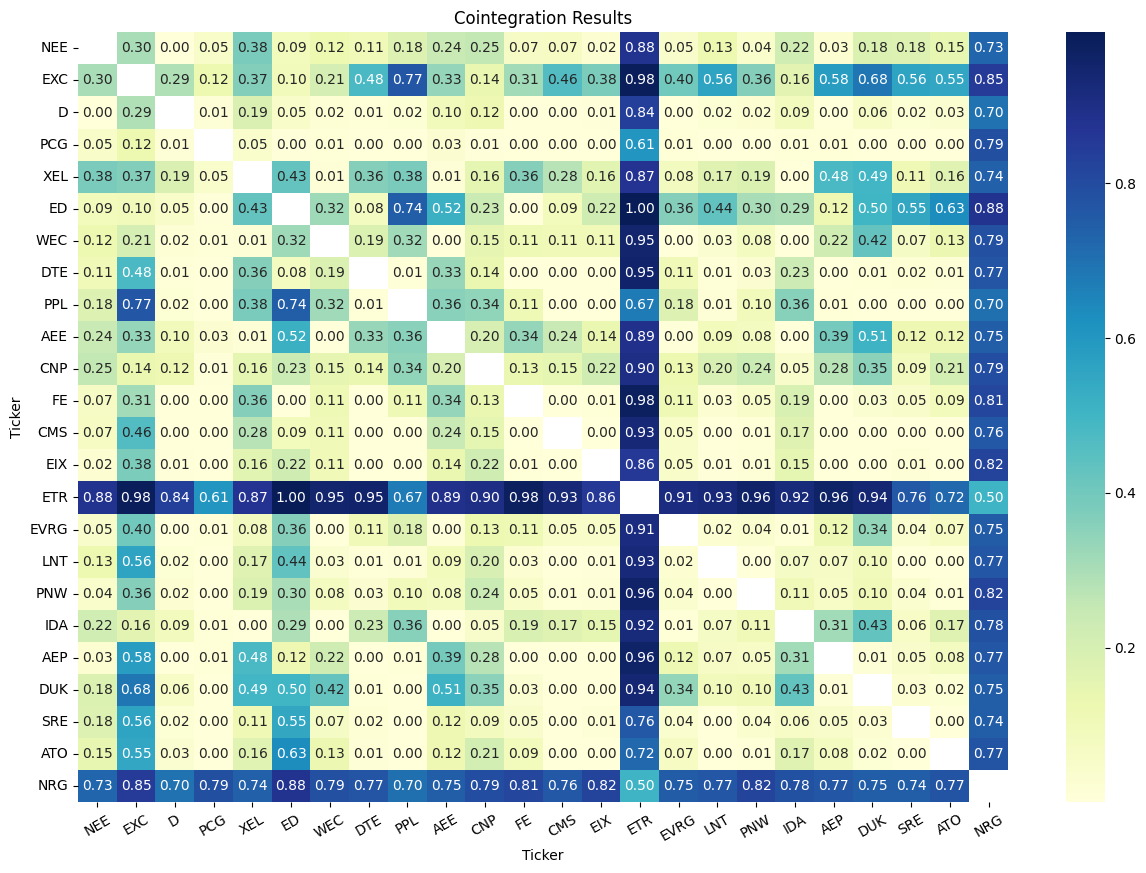

In [9]:
# show the cointegration results as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    cointegration_results.values.astype(np.float32),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
)
plt.grid(False)
plt.title("Cointegration Results")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.xticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=30)
plt.yticks(np.arange(len(utility_tickers)) + 0.5, utility_tickers, rotation=0)
plt.show()


Find the pair with the lowest p-value:

In [10]:
# remove duplicate pairs; order of each pair is not important
lowest_pairs = list(cointegration_results.stack().sort_values().head(20).index)
lowest_pairs = list(set([tuple(sorted(pair)) for pair in lowest_pairs]))
lowest_pair = lowest_pairs[0]

## Plot the spread and prices of the lowest pair

The signal plot shows the trading signals generated from the bollinger bands. When the spread is above the upper band, the signal is 1 (buy), and when the spread is below the lower band, the signal is -1 (sell). When the spread is between the bands, the signal is 0 (hold). Since this is pairs trading, a buy signal is a simultaneous buy of the primary and sell of the secondary, and vice versa for a sell signal. We are only plotting the test period.

In [11]:
primary, secondary = lowest_pair
prices = test_prices[[primary, secondary]]
spread = prices[primary] - prices[secondary]
normalized_prices = prices.apply(lambda x: (x / x.mean()))
normalized_spread = normalized_prices[primary] - normalized_prices[secondary]

# make the normalized spread calculated by the rolling mean of each price
# normalized_spread = normalized_prices[primary].rolling(window=8).mean() - normalized_prices[secondary].rolling(window=8).mean()

# make bands
rolling_window = 8  # This is used for determining how many days ahead to use to calculate the rolling mean
std_multiplier = 1
rolling_mean = (
    normalized_spread.rolling(window=rolling_window).mean()
).dropna()
rolling_std = (normalized_spread.rolling(window=rolling_window).std()).dropna()
upper_band = rolling_mean + (rolling_std * std_multiplier)
lower_band = rolling_mean - (rolling_std * std_multiplier)

# fix the bands and rollings to be the same length as the spread
rolling_mean = rolling_mean.reindex(normalized_spread.index)
upper_band = upper_band.reindex(normalized_spread.index)
lower_band = lower_band.reindex(normalized_spread.index)

# make a series where the value is 1 if the spread is above the upper band and -1 if it is below the lower band
position = pd.Series(
    np.where(
        normalized_spread > upper_band,
        1,
        np.where(normalized_spread < lower_band, -1, 0),
    ),
    index=normalized_spread.index,
)

# plotting
def plot_spread(prices, primary, secondary):
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(
        3, 1, figsize=(15, 12), height_ratios=[2, 0.5, 1]
    )

    # Plot spread in the largest subplot
    normalized_spread.plot(
        ax=ax1, title=f"Normalized Spread of {primary} and {secondary} over test period"
    )
    rolling_mean.plot(
        ax=ax1, label="Rolling Mean", color="red", linewidth=0.5, alpha=0.8
    )
    upper_band.plot(
        ax=ax1, label="Upper Band", color="green", linewidth=0.5, alpha=0.8
    )
    lower_band.plot(
        ax=ax1, label="Lower Band", color="green", linewidth=0.5, alpha=0.8
    )
    ax1.set_ylabel("Quantity")
    ax1.set_xlabel("")
    ax1.grid(True, linestyle="--", alpha=0.7)
    ax1.legend()
    ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # Plot spread direction in the middle subplot
    # don't slant the lines, make them straight
    position.plot(ax=ax2, title=f"Signal of {primary} and {secondary}")
    ax2.set_ylabel("Signal")
    ax2.set_xlabel("")
    ax2.grid(True, linestyle="--", alpha=0.7)
    ax2.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # Plot individual prices in the bottom subplot
    prices.plot(ax=ax3, title=f"Price of {primary} and {secondary} ($)")
    ax3.set_ylabel("Price ($)")
    ax3.set_xlabel("Date")
    ax3.grid(True, linestyle="--", alpha=0.7)

    # if the index is a weekend, put a rectangle on the plot
    for index in prices.index:
        if index.weekday() >= 5 or index.date() in nyse_holidays:
            for ax in [ax3, ax2, ax1]:
                ax.axvspan(index, index, color="gray", alpha=0.08)


    return fig

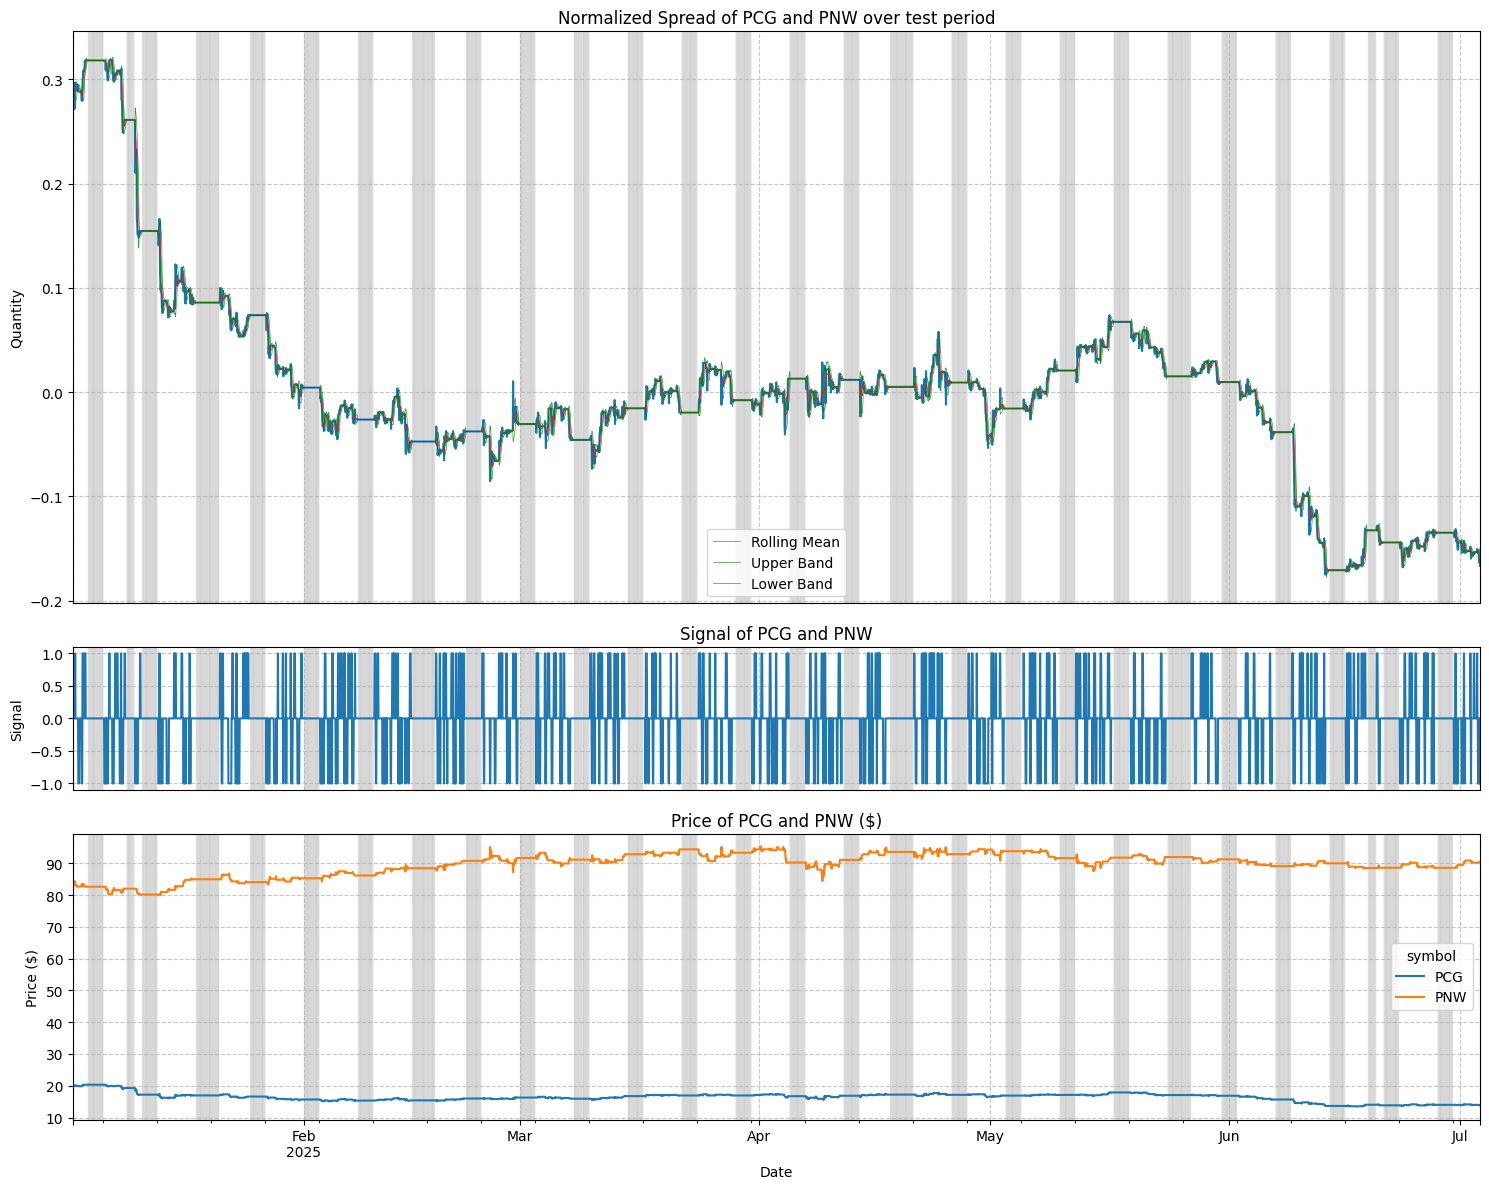

In [12]:
fig = plot_spread(prices, primary, secondary)
plt.tight_layout()
plt.show()